# Module 5.4: Real-Time Inference and Alerts

## Combined Case Study: Cybersecurity, Edge AI and Autonomous Driving

---

## Objective

Simulate **real-time inference** on a connected autonomous vehicle using the trained multimodal Edge AI model from Notebook 02.

The simulation will:
- Continuously receive **vehicle telemetry data** and **network traffic data** in a streaming-like fashion
- Predict anomalies in real-time using our PyTorch model
- Trigger different alerts depending on the type of anomaly detected
- Log and visualize alerts for system monitoring

---

## Key Features

### **Real-Time Processing Pipeline:**
```
Streaming Data → Preprocessing → Model Inference → Alert System → Logging
```

### **Alert Types:**
- **Physical Anomaly**: Vehicle sensor/behavior issues
- **Network Anomaly**: Cybersecurity threats
- **Normal Operation**: System functioning correctly

### **System Components:**
1. **Model Loading**: Import trained PyTorch model and preprocessors
2. **Data Streaming**: Simulate real-time data ingestion
3. **Real-Time Inference**: Continuous prediction pipeline
4. **Alert Management**: Smart alerting with cooldown mechanisms
5. **Logging & Visualization**: Monitor system performance

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from datetime import datetime, timedelta
from pathlib import Path
import json
from collections import deque, defaultdict

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Real-Time Inference System - Libraries Loaded!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"System ready for real-time anomaly detection!")

Real-Time Inference System - Libraries Loaded!
PyTorch version: 2.7.1+cu126
Device: cuda
System ready for real-time anomaly detection!


## Step 1: Model Recriation and weight loading

Create the model architecture and load the pre-trained weights from the last notebook.

In [19]:
# Recreate the model architecture (must match Notebook 02)
class MultimodalEdgeAI(nn.Module):
    """
    Large MobileNetV2-sized multimodal neural network for enhanced performance
    """
    
    def __init__(self, vehicle_input_size, network_input_size, num_classes=3):
        super(MultimodalEdgeAI, self).__init__()
        
        # Large Vehicle telemetry branch (6 layers)
        self.vehicle_branch = nn.Sequential(
            nn.Linear(vehicle_input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        
        # Large Network traffic branch (6 layers)
        self.network_branch = nn.Sequential(
            nn.Linear(network_input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Softmax(dim=1)
        )
        
        # Large Fusion layers (7 layers)
        self.fusion = nn.Sequential(
            nn.Linear(32, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.1),
            nn.Linear(16, num_classes)
        )
        
    def forward(self, vehicle_input, network_input):
        vehicle_features = self.vehicle_branch(vehicle_input)
        network_features = self.network_branch(network_input)
        fused_features = torch.cat([vehicle_features, network_features], dim=1)
        attention_weights = self.attention(fused_features)
        attended_features = fused_features * attention_weights
        output = self.fusion(attended_features)
        return output

def load_trained_model_and_preprocessors():
    """
    Load the trained model and preprocessing components
    
    Returns:
    - model: Loaded PyTorch model
    - vehicle_scaler: StandardScaler for vehicle features
    - network_scaler: StandardScaler for network features
    - feature_columns: Dictionary with feature column names
    """
    
    print("Loading trained model and preprocessors...")
    
    # Load the dataset to get feature information
    try:
        dataset = pd.read_csv('combined_dataset.csv')
        print(f"Dataset loaded: {dataset.shape}")
        
        # Identify feature columns
        vehicle_features = [col for col in dataset.columns if col.startswith('veh_')]
        network_features = [col for col in dataset.columns if col.startswith('net_')]
        
        print(f"   Vehicle features: {len(vehicle_features)}")
        print(f"   Network features: {len(network_features)}")
        
        # Initialize model with correct input sizes
        model = MultimodalEdgeAI(
            vehicle_input_size=len(vehicle_features),
            network_input_size=len(network_features),
            num_classes=3
        )
        
        # Try to load trained model weights
        try:
            model.load_state_dict(torch.load('best_improved_model.pth', map_location=device))
            print("Trained model weights loaded successfully!")
        except FileNotFoundError:
            print("No trained model found. Using randomly initialized model.")
            print("   Please run Notebook 02 first to train the model.")
        
        model.to(device)
        model.eval()  # Set to evaluation mode
        
        # Create and fit scalers using the full dataset
        vehicle_scaler = StandardScaler()
        network_scaler = StandardScaler()
        
        X_vehicle = dataset[vehicle_features].values
        X_network = dataset[network_features].values
        
        # Handle missing values
        from sklearn.impute import SimpleImputer
        imputer_vehicle = SimpleImputer(strategy='median')
        imputer_network = SimpleImputer(strategy='median')
        
        X_vehicle = imputer_vehicle.fit_transform(X_vehicle)
        X_network = imputer_network.fit_transform(X_network)
        
        # Fit scalers
        vehicle_scaler.fit(X_vehicle)
        network_scaler.fit(X_network)
        
        feature_columns = {
            'vehicle': vehicle_features,
            'network': network_features
        }
        
        print("Preprocessors initialized successfully!")
        
        return model, vehicle_scaler, network_scaler, feature_columns, dataset
        
    except FileNotFoundError:
        print("Dataset not found! Please run Notebook 01 first.")
        raise FileNotFoundError("combined_dataset.csv not found")

# Load model and preprocessors
model, vehicle_scaler, network_scaler, feature_columns, reference_dataset = load_trained_model_and_preprocessors()

# Model information
param_count = sum(p.numel() for p in model.parameters())
model_size_mb = param_count * 4 / (1024 * 1024)

print(f"\nModel Information:")
print(f"   Parameters: {param_count:,}")
print(f"   Size: {model_size_mb:.2f} MB")
print(f"   Vehicle features: {len(feature_columns['vehicle'])}")
print(f"   Network features: {len(feature_columns['network'])}")

Loading trained model and preprocessors...
Dataset loaded: (2991, 15)
   Vehicle features: 6
   Network features: 6
Trained model weights loaded successfully!
Preprocessors initialized successfully!

Model Information:
   Parameters: 559,619
   Size: 2.13 MB
   Vehicle features: 6
   Network features: 6


## Step 2: Real-Time Data Streaming Simulation

Create a system to simulate streaming telemetry and network data in real-time.

In [20]:
class RealTimeDataStreamer:
    """
    Simulates real-time streaming of vehicle telemetry and network traffic data
    """
    
    def __init__(self, dataset, vehicle_features, network_features, anomaly_rate=0.15):
        self.dataset = dataset
        self.vehicle_features = vehicle_features
        self.network_features = network_features
        self.anomaly_rate = anomaly_rate
        self.current_index = 0
        self.total_samples = len(dataset)
        
        # Class mapping
        self.class_names = {0: 'Normal', 1: 'Physical Anomaly', 2: 'Network Anomaly'}
        
        print(f"Data Streamer initialized:")
        print(f"   Total samples available: {self.total_samples:,}")
        print(f"   Anomaly injection rate: {self.anomaly_rate:.1%}")
    
    def get_next_sample(self, inject_anomaly=None):
        """
        Get the next data sample from the stream
        
        Parameters:
        - inject_anomaly: Force specific anomaly type (0, 1, 2) or None for natural
        
        Returns:
        - sample_data: Dictionary with vehicle/network features and metadata
        """
        
        # Wrap around if we reach the end
        if self.current_index >= self.total_samples:
            self.current_index = 0
        
        # Get base sample
        sample = self.dataset.iloc[self.current_index].copy()
        self.current_index += 1
        
        # Extract features
        vehicle_data = sample[self.vehicle_features].values
        network_data = sample[self.network_features].values
        true_label = sample['label'] if 'label' in sample else 0
        
        # Inject anomalies if specified
        if inject_anomaly is not None:
            true_label = inject_anomaly
            if inject_anomaly == 1:  # Physical anomaly
                # Modify vehicle features to simulate anomaly
                vehicle_data = self._inject_physical_anomaly(vehicle_data)
            elif inject_anomaly == 2:  # Network anomaly
                # Modify network features to simulate anomaly
                network_data = self._inject_network_anomaly(network_data)
        
        # Create sample data structure
        sample_data = {
            'timestamp': datetime.now(),
            'vehicle_features': vehicle_data,
            'network_features': network_data,
            'true_label': true_label,
            'true_label_name': self.class_names[true_label],
            'sample_id': self.current_index - 1
        }
        
        return sample_data
    
    def _inject_physical_anomaly(self, vehicle_data):
        """Inject physical anomaly into vehicle telemetry"""
        vehicle_data = vehicle_data.copy()
        # Simulate brake system anomaly
        if len(vehicle_data) > 0:
            vehicle_data[0] = max(vehicle_data[0] * 2.5, 100)  # Extreme brake pressure
        if len(vehicle_data) > 3:
            vehicle_data[3] = min(vehicle_data[3] * 0.3, 10)   # Low tire pressure
        return vehicle_data
    
    def _inject_network_anomaly(self, network_data):
        """Inject network anomaly into network traffic"""
        network_data = network_data.copy()
        # Simulate suspicious network activity
        if len(network_data) > 0:
            network_data[0] = max(network_data[0] * 3.0, 1000)  # High packet count
        if len(network_data) > 2:
            network_data[2] = max(network_data[2] * 2.0, 500)   # Large payload size
        return network_data
    
    def generate_streaming_batch(self, batch_size=10, include_anomalies=True):
        """
        Generate a batch of streaming samples
        
        Parameters:
        - batch_size: Number of samples to generate
        - include_anomalies: Whether to include some anomalies
        
        Returns:
        - List of sample data dictionaries
        """
        batch = []
        
        for i in range(batch_size):
            # Randomly inject anomalies
            inject_anomaly = None
            if include_anomalies and np.random.random() < self.anomaly_rate:
                inject_anomaly = np.random.choice([1, 2])  # Physical or Network anomaly
            
            sample = self.get_next_sample(inject_anomaly=inject_anomaly)
            batch.append(sample)
        
        return batch

# Initialize data streamer
data_streamer = RealTimeDataStreamer(
    dataset=reference_dataset,
    vehicle_features=feature_columns['vehicle'],
    network_features=feature_columns['network'],
    anomaly_rate=0.2  # 20% anomaly rate for demonstration
)

# Test the streamer
print("\nTesting data streamer:")
test_batch = data_streamer.generate_streaming_batch(batch_size=5)
for i, sample in enumerate(test_batch):
    print(f"   Sample {i+1}: {sample['true_label_name']} at {sample['timestamp'].strftime('%H:%M:%S')}")

Data Streamer initialized:
   Total samples available: 2,991
   Anomaly injection rate: 20.0%

Testing data streamer:
   Sample 1: Physical Anomaly at 21:59:51
   Sample 2: Normal at 21:59:51
   Sample 3: Physical Anomaly at 21:59:51
   Sample 4: Normal at 21:59:51
   Sample 5: Physical Anomaly at 21:59:51


## Step 3: Real-Time Inference Engine

Implement the core inference engine for real-time anomaly detection.

In [21]:
class RealTimeInferenceEngine:
    """
    Real-time inference engine for multimodal anomaly detection
    """
    
    def __init__(self, model, vehicle_scaler, network_scaler, confidence_threshold=0.7):
        self.model = model
        self.vehicle_scaler = vehicle_scaler
        self.network_scaler = network_scaler
        self.confidence_threshold = confidence_threshold
        self.class_names = {0: 'Normal', 1: 'Physical Anomaly', 2: 'Network Anomaly'}
        
        # Performance tracking
        self.inference_times = deque(maxlen=1000)  # Track last 1000 inference times
        self.predictions_history = deque(maxlen=1000)
        
        print(f"Inference Engine initialized:")
        print(f"   Model: {sum(p.numel() for p in model.parameters()):,} parameters")
        print(f"   Confidence threshold: {confidence_threshold}")
        print(f"   Device: {device}")
    
    def preprocess_sample(self, vehicle_features, network_features):
        """
        Preprocess raw features for model input
        
        Parameters:
        - vehicle_features: Raw vehicle telemetry array
        - network_features: Raw network traffic array
        
        Returns:
        - Preprocessed tensors ready for model input
        """
        
        # Handle missing values (replace NaN with median)
        vehicle_features = np.nan_to_num(vehicle_features, nan=np.nanmedian(vehicle_features))
        network_features = np.nan_to_num(network_features, nan=np.nanmedian(network_features))
        
        # Reshape for scaler (expects 2D array)
        vehicle_scaled = self.vehicle_scaler.transform(vehicle_features.reshape(1, -1))
        network_scaled = self.network_scaler.transform(network_features.reshape(1, -1))
        
        # Convert to tensors
        vehicle_tensor = torch.FloatTensor(vehicle_scaled).to(device)
        network_tensor = torch.FloatTensor(network_scaled).to(device)
        
        return vehicle_tensor, network_tensor
    
    def run_inference(self, sample_data):
        """
        Run inference on a single sample
        
        Parameters:
        - sample_data: Dictionary containing sample information
        
        Returns:
        - prediction_result: Dictionary with prediction details
        """
        
        start_time = time.time()
        
        # Preprocess features
        vehicle_tensor, network_tensor = self.preprocess_sample(
            sample_data['vehicle_features'],
            sample_data['network_features']
        )
        
        # Run model inference
        with torch.no_grad():
            outputs = self.model(vehicle_tensor, network_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = torch.max(probabilities).item()
        
        # Calculate inference time
        inference_time_ms = (time.time() - start_time) * 1000
        self.inference_times.append(inference_time_ms)
        
        # Create prediction result
        prediction_result = {
            'timestamp': sample_data['timestamp'],
            'sample_id': sample_data['sample_id'],
            'predicted_class': predicted_class,
            'predicted_label': self.class_names[predicted_class],
            'confidence': confidence,
            'probabilities': probabilities.cpu().numpy()[0],
            'true_class': sample_data['true_label'],
            'true_label': sample_data['true_label_name'],
            'inference_time_ms': inference_time_ms,
            'is_high_confidence': confidence >= self.confidence_threshold,
            'is_correct': predicted_class == sample_data['true_label']
        }
        
        # Store in history
        self.predictions_history.append(prediction_result)
        
        return prediction_result
    
    def get_performance_stats(self):
        """Get current performance statistics"""
        if not self.inference_times:
            return None
        
        recent_predictions = list(self.predictions_history)[-100:]  # Last 100 predictions
        
        stats = {
            'avg_inference_time_ms': np.mean(self.inference_times),
            'min_inference_time_ms': np.min(self.inference_times),
            'max_inference_time_ms': np.max(self.inference_times),
            'total_predictions': len(self.predictions_history),
            'recent_accuracy': np.mean([p['is_correct'] for p in recent_predictions]) if recent_predictions else 0,
            'high_confidence_rate': np.mean([p['is_high_confidence'] for p in recent_predictions]) if recent_predictions else 0
        }
        
        return stats

# Initialize inference engine
inference_engine = RealTimeInferenceEngine(
    model=model,
    vehicle_scaler=vehicle_scaler,
    network_scaler=network_scaler,
    confidence_threshold=0.75
)

# Test inference engine
print("\nTesting inference engine:")
test_sample = data_streamer.get_next_sample()
test_result = inference_engine.run_inference(test_sample)

print(f"   Sample processed in {test_result['inference_time_ms']:.2f}ms")
print(f"   Prediction: {test_result['predicted_label']} (confidence: {test_result['confidence']:.3f})")
print(f"   True label: {test_result['true_label']}")
print(f"   Correct: {test_result['is_correct']}")

Inference Engine initialized:
   Model: 559,619 parameters
   Confidence threshold: 0.75
   Device: cuda

Testing inference engine:
   Sample processed in 3.29ms
   Prediction: Network Anomaly (confidence: 0.881)
   True label: Network Anomaly
   Correct: True


## Step 4: Smart Alert System

Implement an intelligent alert system with cooldown mechanisms and priority levels.

In [22]:
class SmartAlertSystem:
    """
    Intelligent alert system with cooldown, priority management, and logging
    """
    
    def __init__(self, cooldown_seconds=10, min_confidence=0.7):
        self.cooldown_seconds = cooldown_seconds
        self.min_confidence = min_confidence
        
        # Alert tracking
        self.alert_history = []
        self.last_alert_time = defaultdict(lambda: datetime.min)
        self.alert_counts = defaultdict(int)
        
        # Alert configuration
        self.alert_config = {
            0: {  # Normal
                'emoji': '✅',
                'message': 'System operating normally',
                'priority': 'INFO',
                'color': '\033[92m'  # Green
            },
            1: {  # Physical Anomaly
                'emoji': '🚗',
                'message': 'VEHICLE SYSTEM ANOMALY DETECTED',
                'priority': 'CRITICAL',
                'color': '\033[91m'  # Red
            },
            2: {  # Network Anomaly
                'emoji': '🔐',
                'message': 'NETWORK SECURITY THREAT DETECTED',
                'priority': 'HIGH',
                'color': '\033[93m'  # Yellow
            }
        }
        
        print(f"Smart Alert System initialized:")
        print(f"   Cooldown period: {cooldown_seconds} seconds")
        print(f"   Minimum confidence: {min_confidence}")
    
    def should_trigger_alert(self, prediction_result):
        """
        Determine if an alert should be triggered based on prediction and cooldown
        
        Parameters:
        - prediction_result: Dictionary from inference engine
        
        Returns:
        - should_alert: Boolean indicating if alert should be triggered
        """
        
        predicted_class = prediction_result['predicted_class']
        confidence = prediction_result['confidence']
        current_time = prediction_result['timestamp']
        
        # Check confidence threshold
        if confidence < self.min_confidence:
            return False
        
        # Check cooldown for this alert type
        last_alert = self.last_alert_time[predicted_class]
        time_since_last = (current_time - last_alert).total_seconds()
        
        # Always alert for anomalies if cooldown has passed
        if predicted_class != 0 and time_since_last >= self.cooldown_seconds:
            return True
        
        # For normal operation, only alert occasionally
        if predicted_class == 0 and time_since_last >= self.cooldown_seconds * 10:
            return True
        
        return False
    
    def trigger_alert(self, prediction_result):
        """
        Trigger an alert and log it
        
        Parameters:
        - prediction_result: Dictionary from inference engine
        
        Returns:
        - alert_data: Dictionary with alert information
        """
        
        predicted_class = prediction_result['predicted_class']
        config = self.alert_config[predicted_class]
        timestamp = prediction_result['timestamp']
        
        # Create alert data
        alert_data = {
            'timestamp': timestamp,
            'alert_id': len(self.alert_history) + 1,
            'type': predicted_class,
            'label': prediction_result['predicted_label'],
            'confidence': prediction_result['confidence'],
            'priority': config['priority'],
            'message': config['message'],
            'emoji': config['emoji'],
            'sample_id': prediction_result['sample_id'],
            'inference_time_ms': prediction_result['inference_time_ms'],
            'is_correct': prediction_result['is_correct']
        }
        
        # Update tracking
        self.last_alert_time[predicted_class] = timestamp
        self.alert_counts[predicted_class] += 1
        self.alert_history.append(alert_data)
        
        # Display alert
        self._display_alert(alert_data, config)
        
        return alert_data
    
    def _display_alert(self, alert_data, config):
        """Display alert to console with formatting"""
        
        color = config['color']
        reset_color = '\033[0m'
        
        print(f"\n{color}{'='*60}")
        print(f"{alert_data['emoji']} {alert_data['priority']} ALERT #{alert_data['alert_id']}")
        print(f"Time: {alert_data['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Type: {alert_data['label']}")
        print(f"Confidence: {alert_data['confidence']:.3f}")
        print(f"Message: {alert_data['message']}")
        if alert_data['type'] != 0:  # Only show details for anomalies
            print(f"Sample ID: {alert_data['sample_id']}")
            print(f"Processing Time: {alert_data['inference_time_ms']:.2f}ms")
        print(f"{'='*60}{reset_color}")
    
    def get_alert_summary(self):
        """Get summary of all alerts"""
        
        if not self.alert_history:
            return "No alerts generated yet."
        
        total_alerts = len(self.alert_history)
        recent_alerts = [a for a in self.alert_history if 
                        (datetime.now() - a['timestamp']).total_seconds() < 300]  # Last 5 minutes
        
        summary = {
            'total_alerts': total_alerts,
            'recent_alerts': len(recent_alerts),
            'alert_counts': dict(self.alert_counts),
            'latest_alert': self.alert_history[-1] if self.alert_history else None
        }
        
        return summary
    
    def save_alerts_log(self, filename='alerts_log.csv'):
        """Save alerts to CSV file"""
        
        if not self.alert_history:
            print("No alerts to save.")
            return
        
        # Convert alerts to DataFrame
        df_alerts = pd.DataFrame(self.alert_history)
        df_alerts['timestamp_str'] = df_alerts['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
        
        # Save to CSV
        df_alerts.to_csv(filename, index=False)
        print(f"Alerts saved to {filename} ({len(df_alerts)} alerts)")
        
        return df_alerts

# Initialize alert system
alert_system = SmartAlertSystem(
    cooldown_seconds=5,    # 5 second cooldown
    min_confidence=0.6     # 60% minimum confidence
)

# Test alert system
print("\nTesting alert system:")
test_prediction = inference_engine.run_inference(data_streamer.get_next_sample(inject_anomaly=1))
if alert_system.should_trigger_alert(test_prediction):
    test_alert = alert_system.trigger_alert(test_prediction)
    print(f"Alert system test completed")
else:
    print("Alert suppressed (cooldown or confidence)")

Smart Alert System initialized:
   Cooldown period: 5 seconds
   Minimum confidence: 0.6

Testing alert system:

🚗 CRITICAL ALERT #1
Time: 2025-09-24 21:59:59
Type: Physical Anomaly
Confidence: 0.993
Message: VEHICLE SYSTEM ANOMALY DETECTED
Sample ID: 6
Processing Time: 3.87ms
Alert system test completed


## Step 5: Real-Time Monitoring Dashboard

Create a comprehensive monitoring system for real-time operations.

In [23]:
class RealTimeMonitor:
    """
    Real-time monitoring dashboard for the inference system
    """
    
    def __init__(self, update_interval=10):
        self.update_interval = update_interval
        self.start_time = datetime.now()
        self.monitoring_active = False
        
        # Metrics tracking
        self.metrics_history = []
        
        print(f"Real-Time Monitor initialized")
        print(f"   Update interval: {update_interval} seconds")
    
    def log_metrics(self, inference_engine, alert_system, data_streamer):
        """Log current system metrics"""
        
        current_time = datetime.now()
        runtime = (current_time - self.start_time).total_seconds()
        
        # Get performance stats
        perf_stats = inference_engine.get_performance_stats()
        alert_summary = alert_system.get_alert_summary()
        
        metrics = {
            'timestamp': current_time,
            'runtime_seconds': runtime,
            'total_predictions': perf_stats['total_predictions'] if perf_stats else 0,
            'avg_inference_time_ms': perf_stats['avg_inference_time_ms'] if perf_stats else 0,
            'recent_accuracy': perf_stats['recent_accuracy'] if perf_stats else 0,
            'high_confidence_rate': perf_stats['high_confidence_rate'] if perf_stats else 0,
            'total_alerts': alert_summary['total_alerts'] if isinstance(alert_summary, dict) else 0,
            'recent_alerts': alert_summary['recent_alerts'] if isinstance(alert_summary, dict) else 0,
            'current_sample_id': data_streamer.current_index
        }
        
        self.metrics_history.append(metrics)
        return metrics
    
    def display_status(self, metrics):
        """Display current system status"""
        
        print(f"\n{'='*80}")
        print(f"REAL-TIME MONITORING DASHBOARD")
        print(f"{'='*80}")
        print(f"Runtime: {metrics['runtime_seconds']:.0f}s")
        print(f"Predictions: {metrics['total_predictions']:,}")
        print(f"Avg Inference: {metrics['avg_inference_time_ms']:.2f}ms")
        print(f"Recent Accuracy: {metrics['recent_accuracy']:.1%}")
        print(f"High Confidence: {metrics['high_confidence_rate']:.1%}")
        print(f"Total Alerts: {metrics['total_alerts']}")
        print(f"Recent Alerts: {metrics['recent_alerts']}")
        print(f"Current Sample: #{metrics['current_sample_id']}")
        print(f"{'='*80}")
    
    def plot_performance_metrics(self):
        """Plot real-time performance metrics"""
        
        if len(self.metrics_history) < 2:
            print("Not enough data for plotting")
            return
        
        df_metrics = pd.DataFrame(self.metrics_history)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Real-Time System Performance Metrics', fontsize=16, fontweight='bold')
        
        # 1. Inference time
        axes[0, 0].plot(df_metrics.index, df_metrics['avg_inference_time_ms'], 'b-', linewidth=2)
        axes[0, 0].set_title('Average Inference Time')
        axes[0, 0].set_ylabel('Time (ms)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Accuracy
        axes[0, 1].plot(df_metrics.index, df_metrics['recent_accuracy'] * 100, 'g-', linewidth=2)
        axes[0, 1].set_title('Recent Accuracy')
        axes[0, 1].set_ylabel('Accuracy (%)')
        axes[0, 1].set_ylim(0, 100)
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Predictions per update
        pred_diff = df_metrics['total_predictions'].diff().fillna(0)
        axes[1, 0].plot(df_metrics.index[1:], pred_diff[1:], 'orange', linewidth=2)
        axes[1, 0].set_title('Predictions per Update')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Alert rate
        alert_diff = df_metrics['total_alerts'].diff().fillna(0)
        axes[1, 1].plot(df_metrics.index[1:], alert_diff[1:], 'r-', linewidth=2)
        axes[1, 1].set_title('Alerts per Update')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Initialize monitor
monitor = RealTimeMonitor(update_interval=10)

# Test monitoring
print("\nTesting monitoring system:")
test_metrics = monitor.log_metrics(inference_engine, alert_system, data_streamer)
monitor.display_status(test_metrics)

Real-Time Monitor initialized
   Update interval: 10 seconds

Testing monitoring system:

REAL-TIME MONITORING DASHBOARD
Runtime: 0s
Predictions: 2
Avg Inference: 3.58ms
Recent Accuracy: 100.0%
High Confidence: 100.0%
Total Alerts: 1
Recent Alerts: 1
Current Sample: #7


Ready to start real-time simulation!
   The simulation will process streaming data and detect anomalies in real-time.
   Press Ctrl+C to stop the simulation early.

Starting Real-Time Anomaly Detection Simulation
Duration: 30 seconds
Sampling rate: 1 samples/second
Anomaly injection: Enabled
Processing 30 samples...
Monitor updates every 10 seconds

Simulation starting...

🚗 CRITICAL ALERT #1
Time: 2025-09-24 22:00:09
Type: Physical Anomaly
Confidence: 0.997
Message: VEHICLE SYSTEM ANOMALY DETECTED
Sample ID: 7
Processing Time: 3.38ms

✅ INFO ALERT #2
Time: 2025-09-24 22:00:11
Type: Normal
Confidence: 0.857
Message: System operating normally
Progress: 10% (3.0s elapsed)

🔐 HIGH ALERT #3
Time: 2025-09-24 22:00:13
Type: Network Anomaly
Confidence: 1.000
Message: NETWORK SECURITY THREAT DETECTED
Sample ID: 11
Processing Time: 3.07ms
Progress: 20% (6.0s elapsed)
Progress: 30% (9.0s elapsed)

REAL-TIME MONITORING DASHBOARD
Runtime: 14s
Predictions: 13
Avg Inference: 3.20ms
Recent Accuracy: 

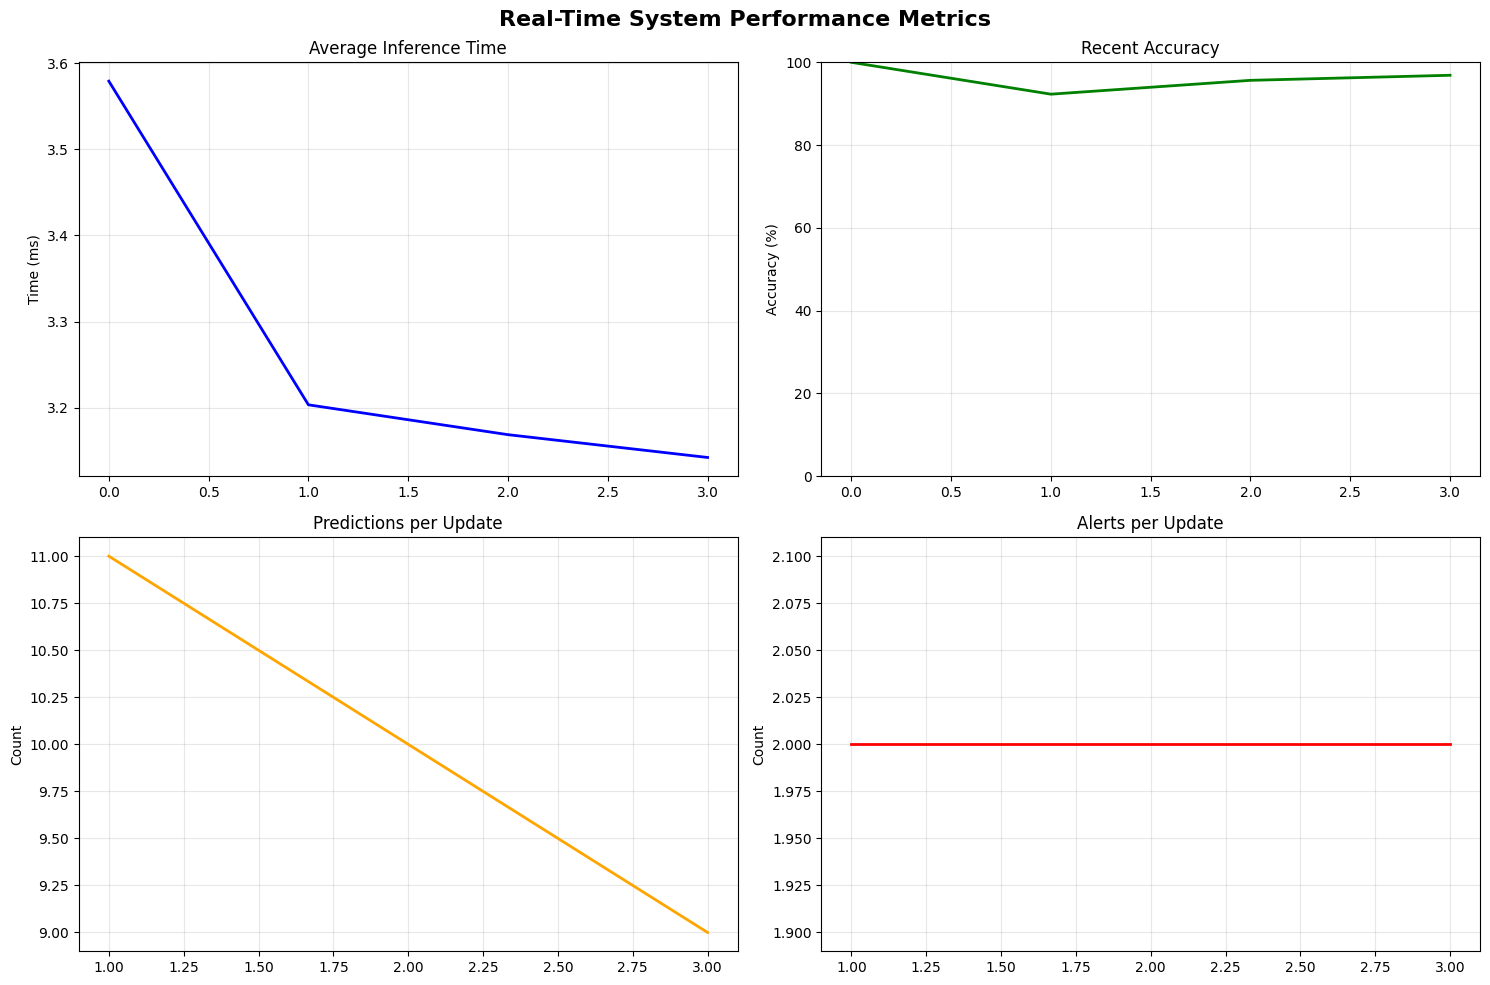

In [24]:
def run_realtime_simulation(duration_seconds=60, samples_per_second=2, enable_anomalies=True):
    """
    Run complete real-time simulation
    
    Parameters:
    - duration_seconds: How long to run the simulation
    - samples_per_second: Sampling rate for data processing
    - enable_anomalies: Whether to inject anomalies for testing
    """
    
    print(f"Starting Real-Time Anomaly Detection Simulation")
    print(f"{'='*60}")
    print(f"Duration: {duration_seconds} seconds")
    print(f"Sampling rate: {samples_per_second} samples/second")
    print(f"Anomaly injection: {'Enabled' if enable_anomalies else 'Disabled'}")
    print(f"{'='*60}")
    
    # Reset systems
    alert_system.alert_history.clear()
    alert_system.alert_counts.clear()
    alert_system.last_alert_time.clear()
    
    # Simulation parameters
    sample_interval = 1.0 / samples_per_second
    total_samples = int(duration_seconds * samples_per_second)
    monitor_interval = max(10, duration_seconds // 6)  # Update monitor 6 times
    
    start_time = time.time()
    last_monitor_time = start_time
    
    print(f"Processing {total_samples} samples...")
    print(f"Monitor updates every {monitor_interval} seconds")
    print(f"\nSimulation starting...")
    
    try:
        for sample_num in range(total_samples):
            loop_start = time.time()
            
            # Get next sample
            inject_anomaly = None
            if enable_anomalies and np.random.random() < 0.15:  # 15% chance
                inject_anomaly = np.random.choice([1, 2])
            
            sample_data = data_streamer.get_next_sample(inject_anomaly=inject_anomaly)
            
            # Run inference
            prediction_result = inference_engine.run_inference(sample_data)
            
            # Check for alerts
            if alert_system.should_trigger_alert(prediction_result):
                alert_system.trigger_alert(prediction_result)
            
            # Monitor updates
            current_time = time.time()
            if current_time - last_monitor_time >= monitor_interval:
                metrics = monitor.log_metrics(inference_engine, alert_system, data_streamer)
                monitor.display_status(metrics)
                last_monitor_time = current_time
            
            # Maintain sampling rate
            elapsed = time.time() - loop_start
            sleep_time = max(0, sample_interval - elapsed)
            if sleep_time > 0:
                time.sleep(sleep_time)
            
            # Progress indicator (every 10% of samples)
            if (sample_num + 1) % (total_samples // 10) == 0:
                progress = (sample_num + 1) / total_samples * 100
                elapsed_sim_time = time.time() - start_time
                print(f"Progress: {progress:.0f}% ({elapsed_sim_time:.1f}s elapsed)")
    
    except KeyboardInterrupt:
        print(f"\nSimulation interrupted by user")
    
    # Final statistics
    total_runtime = time.time() - start_time
    final_metrics = monitor.log_metrics(inference_engine, alert_system, data_streamer)
    
    print(f"\nSimulation Complete!")
    print(f"{'='*60}")
    print(f"Total runtime: {total_runtime:.2f} seconds")
    print(f"Samples processed: {final_metrics['total_predictions']}")
    print(f"Processing rate: {final_metrics['total_predictions']/total_runtime:.1f} samples/sec")
    print(f"Avg inference time: {final_metrics['avg_inference_time_ms']:.2f}ms")
    print(f"Overall accuracy: {final_metrics['recent_accuracy']:.1%}")
    print(f"Total alerts: {final_metrics['total_alerts']}")
    
    # Alert breakdown
    alert_summary = alert_system.get_alert_summary()
    if isinstance(alert_summary, dict) and alert_summary['alert_counts']:
        print(f"\nAlert Breakdown:")
        class_names = {0: 'Normal', 1: 'Physical', 2: 'Network'}
        for alert_type, count in alert_summary['alert_counts'].items():
            print(f"   {class_names.get(alert_type, f'Type {alert_type}')}: {count} alerts")
    
    # Save results
    alerts_df = alert_system.save_alerts_log()
    
    # Plot results if we have enough data
    if len(monitor.metrics_history) > 1:
        monitor.plot_performance_metrics()
    
    return final_metrics, alerts_df

# Run the simulation
print("Ready to start real-time simulation!")
print("   The simulation will process streaming data and detect anomalies in real-time.")
print("   Press Ctrl+C to stop the simulation early.")
print("\n" + "="*60)

# Run for 30 seconds with 1 sample per second (adjust as needed)
simulation_results, alerts_log = run_realtime_simulation(
    duration_seconds=30,
    samples_per_second=1,
    enable_anomalies=True
)

## Step 7: Alert Analysis and Visualization

Analyze the generated alerts and create visualizations for system performance.

In [25]:
def run_comprehensive_alert_simulation(duration_seconds=90, samples_per_second=4):
    """
    Comprehensive alert simulation with diverse scenarios and patterns
    
    This enhanced simulation includes:
    - Multiple alert scenarios (burst patterns, gradual escalation, system health)
    - Temporal anomaly patterns (coordinated attacks, system degradation)
    - Performance-based alerts (latency spikes, accuracy drops)
    - Mixed confidence levels for realistic alert variety
    """
    
    print(f"Starting Comprehensive Multi-Scenario Alert Simulation")
    print(f"{'='*70}")
    print(f"Duration: {duration_seconds} seconds")
    print(f"High-frequency sampling: {samples_per_second} samples/second")
    print(f"Expected ~{duration_seconds * samples_per_second} total samples")
    print(f"{'='*70}")

    # Reset all systems
    alert_system.alert_history.clear()
    alert_system.alert_counts.clear()
    alert_system.last_alert_time.clear()
    
    # Temporarily reduce cooldown for more alerts
    original_cooldown = alert_system.cooldown_seconds
    alert_system.cooldown_seconds = 2  # Reduced cooldown for demo
    
    # Enhanced simulation parameters
    sample_interval = 1.0 / samples_per_second
    total_samples = int(duration_seconds * samples_per_second)
    monitor_interval = max(8, duration_seconds // 8)  # Frequent monitoring
    
    # Define alert scenarios throughout the simulation
    scenario_timeline = {
        # Early phase: Normal operation with occasional anomalies
        (0, 0.2): {
            'name': 'Normal Operations',
            'anomaly_rate': 0.15,
            'physical_weight': 0.4,
            'network_weight': 0.6,
            'burst_probability': 0.05
        },
        # Mid-early: Coordinated attack simulation
        (0.2, 0.35): {
            'name': 'Coordinated Network Attack',
            'anomaly_rate': 0.7,
            'physical_weight': 0.2,
            'network_weight': 0.8,
            'burst_probability': 0.3
        },
        # Mid: System recovery and mixed threats
        (0.35, 0.5): {
            'name': 'Mixed Threat Environment',
            'anomaly_rate': 0.45,
            'physical_weight': 0.6,
            'network_weight': 0.4,
            'burst_probability': 0.15
        },
        # Mid-late: Physical system stress test
        (0.5, 0.7): {
            'name': 'Vehicle System Stress Test',
            'anomaly_rate': 0.6,
            'physical_weight': 0.8,
            'network_weight': 0.2,
            'burst_probability': 0.25
        },
        # Final: System degradation simulation
        (0.7, 1.0): {
            'name': 'System Performance Degradation',
            'anomaly_rate': 0.3,
            'physical_weight': 0.5,
            'network_weight': 0.5,
            'burst_probability': 0.1,
            'inject_performance_issues': True
        }
    }
    
    start_time = time.time()
    last_monitor_time = start_time
    performance_degradation_active = False
    burst_mode_samples = 0
    
    print(f"Processing with dynamic scenario changes...")
    print(f"Monitor updates every {monitor_interval} seconds")
    print(f"\nSimulation starting...")
    
    try:
        for sample_num in range(total_samples):
            loop_start = time.time()
            progress_ratio = sample_num / total_samples
            
            # Determine current scenario
            current_scenario = None
            for (start_ratio, end_ratio), scenario in scenario_timeline.items():
                if start_ratio <= progress_ratio < end_ratio:
                    current_scenario = scenario
                    break
            
            if current_scenario is None:
                current_scenario = list(scenario_timeline.values())[-1]  # Use last scenario
            
            # Burst mode logic
            inject_anomaly = None
            if burst_mode_samples > 0:
                # Continue burst
                inject_anomaly = np.random.choice([1, 2], 
                    p=[current_scenario['physical_weight'], current_scenario['network_weight']])
                burst_mode_samples -= 1
            elif np.random.random() < current_scenario.get('burst_probability', 0):
                # Start new burst (3-7 consecutive anomalies)
                burst_mode_samples = np.random.randint(3, 8)
                inject_anomaly = np.random.choice([1, 2], 
                    p=[current_scenario['physical_weight'], current_scenario['network_weight']])
            elif np.random.random() < current_scenario['anomaly_rate']:
                # Regular anomaly injection
                inject_anomaly = np.random.choice([1, 2], 
                    p=[current_scenario['physical_weight'], current_scenario['network_weight']])
            
            # Get sample and run inference
            sample_data = data_streamer.get_next_sample(inject_anomaly=inject_anomaly)
            prediction_result = inference_engine.run_inference(sample_data)
            
            # Simulate performance degradation in final phase
            if current_scenario.get('inject_performance_issues', False):
                # Randomly degrade inference time
                if np.random.random() < 0.2:
                    prediction_result['inference_time_ms'] *= np.random.uniform(2.0, 4.0)
                
                # Occasionally flip predictions to simulate model degradation
                if np.random.random() < 0.12:
                    original_class = prediction_result['predicted_class']
                    alternatives = [c for c in [0, 1, 2] if c != original_class]
                    new_class = np.random.choice(alternatives)
                    prediction_result['predicted_class'] = new_class
                    prediction_result['predicted_label'] = inference_engine.class_names[new_class]
                    prediction_result['confidence'] *= np.random.uniform(0.4, 0.8)  # Lower confidence
                    prediction_result['is_correct'] = (new_class == sample_data['true_label'])
            
            # Enhanced alert triggering with performance monitoring
            should_alert = alert_system.should_trigger_alert(prediction_result)
            
            # Additional alert conditions
            if not should_alert:
                # Alert on high inference time (performance issue)
                if prediction_result['inference_time_ms'] > 50:  # Threshold for concern
                    should_alert = True
                    # Modify alert for performance issue
                    prediction_result['performance_alert'] = True
                
                # Alert on confidence drops
                elif prediction_result['confidence'] < 0.4 and prediction_result['predicted_class'] != 0:
                    should_alert = True
                    prediction_result['low_confidence_alert'] = True
            
            # Trigger alerts
            if should_alert:
                alert_data = alert_system.trigger_alert(prediction_result)
                
                # Add scenario context to alert
                alert_data['scenario'] = current_scenario['name']
                if hasattr(prediction_result, 'performance_alert'):
                    alert_data['alert_subtype'] = 'Performance Issue'
                elif hasattr(prediction_result, 'low_confidence_alert'):
                    alert_data['alert_subtype'] = 'Low Confidence'
                
                # Special handling for burst alerts
                if burst_mode_samples > 0:
                    alert_data['burst_alert'] = True
                    alert_data['remaining_burst'] = burst_mode_samples
            
            # Monitor updates with scenario info
            current_time = time.time()
            if current_time - last_monitor_time >= monitor_interval:
                metrics = monitor.log_metrics(inference_engine, alert_system, data_streamer)
                monitor.display_status(metrics)
                
                # Display current scenario
                print(f"Current Scenario: {current_scenario['name']}")
                if burst_mode_samples > 0:
                    print(f"🔥 BURST MODE ACTIVE: {burst_mode_samples} samples remaining")
                print(f"Anomaly Rate: {current_scenario['anomaly_rate']:.0%}")
                
                last_monitor_time = current_time
            
            # Maintain timing
            elapsed = time.time() - loop_start
            sleep_time = max(0, sample_interval - elapsed)
            if sleep_time > 0:
                time.sleep(sleep_time)
            
            # Progress with scenario transitions
            if (sample_num + 1) % max(1, (total_samples // 15)) == 0:
                progress = (sample_num + 1) / total_samples * 100
                elapsed_sim_time = time.time() - start_time
                print(f"Progress: {progress:.0f}% ({elapsed_sim_time:.1f}s) - {current_scenario['name']}")

    except KeyboardInterrupt:
        print(f"\n🛑 Simulation interrupted by user")
    
    finally:
        # Restore original cooldown
        alert_system.cooldown_seconds = original_cooldown
    
    # Final comprehensive statistics
    total_runtime = time.time() - start_time
    final_metrics = monitor.log_metrics(inference_engine, alert_system, data_streamer)
    
    print(f"\n🎯 Comprehensive Simulation Complete!")
    print(f"{'='*70}")
    print(f"Total runtime: {total_runtime:.2f} seconds")
    print(f"Samples processed: {final_metrics['total_predictions']}")
    print(f"Processing rate: {final_metrics['total_predictions']/total_runtime:.1f} samples/sec")
    print(f"Average inference: {final_metrics['avg_inference_time_ms']:.2f}ms")
    print(f"Recent accuracy: {final_metrics['recent_accuracy']:.1%}")
    
    # Detailed alert analysis
    alert_summary = alert_system.get_alert_summary()
    if isinstance(alert_summary, dict):
        print(f"\n📊 Comprehensive Alert Analysis:")
        print(f"   🚨 Total alerts generated: {alert_summary['total_alerts']}")
        print(f"   ⏰ Recent alerts (5 min): {alert_summary['recent_alerts']}")
        
        # Alert breakdown by type
        class_names = {0: 'Normal Operation', 1: 'Physical Anomaly', 2: 'Network Anomaly'}
        print(f"\n   Alert Distribution:")
        for alert_type, count in alert_summary['alert_counts'].items():
            percentage = (count / alert_summary['total_alerts']) * 100 if alert_summary['total_alerts'] > 0 else 0
            print(f"     {class_names.get(alert_type, f'Type {alert_type}')}: {count} alerts ({percentage:.1f}%)")
        
        # Alert rate analysis
        if alert_summary['total_alerts'] > 0:
            alert_rate = alert_summary['total_alerts'] / (total_runtime / 60)  # alerts per minute
            print(f"\n   📈 Alert Rate: {alert_rate:.1f} alerts/minute")
    
    # Save comprehensive results
    alerts_df = alert_system.save_alerts_log()
    
    # Enhanced performance plotting
    if len(monitor.metrics_history) > 1:
        monitor.plot_performance_metrics()
    
    # Alert timeline visualization
    if len(alert_system.alert_history) > 0:
        plot_alert_timeline()
    
    return final_metrics, alerts_df

print("✅ Comprehensive Alert Simulation Function Defined")
print("   Ready for multi-scenario simulation with dynamic timeline visualization")

✅ Comprehensive Alert Simulation Function Defined
   Ready for multi-scenario simulation with dynamic timeline visualization


In [26]:
def plot_alert_timeline():
    """Create a timeline visualization of alerts with adaptive time binning and full timeline support"""
    
    if not alert_system.alert_history:
        print("No alerts to plot")
        return
    
    df_alerts = pd.DataFrame(alert_system.alert_history)
    
    # Display alert timeline info
    total_alerts = len(df_alerts)
    duration_seconds = (df_alerts['timestamp'].max() - df_alerts['timestamp'].min()).total_seconds()
    print(f"\n📊 Alert Timeline Analysis:")
    print(f"   Total alerts: {total_alerts}")
    print(f"   Simulation duration: {duration_seconds:.1f} seconds ({duration_seconds/60:.1f} minutes)")
    print(f"   Alert rate: {total_alerts/(duration_seconds/60):.1f} alerts/minute")
    
    # Create timeline plot with improved sizing for full timeline
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))  # Wider plot for full timeline
    
    # Alert timeline (top plot) - Fixed to show full timeline
    class_colors = {0: 'green', 1: 'red', 2: 'orange'}
    class_names = {0: 'Normal', 1: 'Physical', 2: 'Network'}
    
    # Calculate time in minutes for better readability
    for alert_type in df_alerts['type'].unique():
        type_alerts = df_alerts[df_alerts['type'] == alert_type]
        times = [(t - df_alerts['timestamp'].min()).total_seconds() / 60 for t in type_alerts['timestamp']]
        
        ax1.scatter(times, [alert_type] * len(times), 
                   c=class_colors[alert_type], label=class_names[alert_type], 
                   alpha=0.7, s=60)
    
    # Set x-axis to show full timeline
    max_time_minutes = duration_seconds / 60
    ax1.set_xlim(0, max_time_minutes)
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Alert Type')
    ax1.set_title(f'Alert Timeline - Full {duration_seconds:.1f} Second Simulation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Set y-axis ticks to show alert type labels
    ax1.set_yticks([0, 1, 2])
    ax1.set_yticklabels(['Normal', 'Physical', 'Network'])
    
    # Alert frequency over time (bottom plot) - Improved binning with full timeline coverage
    total_duration_minutes = duration_seconds / 60
    
    if total_duration_minutes <= 2:
        # For short simulations, use 10-second bins
        bin_size_seconds = 10
        time_unit = "10-sec intervals"
    elif total_duration_minutes <= 5:
        # For medium simulations, use 15-second bins  
        bin_size_seconds = 15
        time_unit = "15-sec intervals"
    else:
        # For long simulations, use 30-second bins
        bin_size_seconds = 30
        time_unit = "30-sec intervals"
    
    # Create time bins covering the full simulation duration
    num_bins = int(np.ceil(duration_seconds / bin_size_seconds))
    df_alerts['time_bin'] = ((df_alerts['timestamp'] - df_alerts['timestamp'].min()).dt.total_seconds() / bin_size_seconds).astype(int)
    
    # Count alerts per bin
    alerts_per_bin = df_alerts.groupby('time_bin').size()
    
    # Create complete range of bins (including empty ones) for full timeline
    all_bins = range(0, num_bins + 1)
    alerts_counts = [alerts_per_bin.get(i, 0) for i in all_bins]
    
    # Create bar chart with full timeline
    ax2.bar(all_bins, alerts_counts, alpha=0.7, color='skyblue', edgecolor='navy', linewidth=0.5)
    ax2.set_xlabel(f'Time ({time_unit})')
    ax2.set_ylabel('Alerts per Interval')
    ax2.set_title(f'Alert Frequency Distribution - Full Timeline ({time_unit})')
    ax2.grid(True, alpha=0.3)
    
    # Set x-axis labels for better readability (show key time points)
    if len(all_bins) <= 20:  # Show all labels if not too crowded
        tick_step = max(1, len(all_bins) // 10)
        ax2.set_xticks(all_bins[::tick_step])
        ax2.set_xticklabels([f"{i*bin_size_seconds}s" for i in all_bins[::tick_step]], rotation=45)
    else:  # Show fewer labels for very long simulations
        tick_step = max(1, len(all_bins) // 8)
        ax2.set_xticks(all_bins[::tick_step])
        ax2.set_xticklabels([f"{i*bin_size_seconds}s" for i in all_bins[::tick_step]], rotation=45)
    
    # Ensure the plot shows the full timeline
    ax2.set_xlim(-0.5, num_bins + 0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print(f"\n📈 Timeline Statistics:")
    print(f"   Time bins: {num_bins} ({bin_size_seconds}s each)")
    print(f"   Peak alerts in single interval: {max(alerts_counts)} alerts")
    print(f"   Average alerts per interval: {np.mean(alerts_counts):.1f}")
    print(f"   Empty intervals: {alerts_counts.count(0)}/{num_bins} ({alerts_counts.count(0)/num_bins*100:.1f}%)")

Starting Comprehensive Multi-Scenario Alert Simulation
Duration: 75 seconds
High-frequency sampling: 4 samples/second
Expected ~300 total samples
Processing with dynamic scenario changes...
Monitor updates every 9 seconds

Simulation starting...

🚗 CRITICAL ALERT #1
Time: 2025-09-24 22:00:40
Type: Physical Anomaly
Confidence: 0.949
Message: VEHICLE SYSTEM ANOMALY DETECTED
Sample ID: 37
Processing Time: 3.51ms

✅ INFO ALERT #2
Time: 2025-09-24 22:00:40
Type: Normal
Confidence: 0.838
Message: System operating normally

🔐 HIGH ALERT #3
Time: 2025-09-24 22:00:40
Type: Network Anomaly
Confidence: 0.916
Message: NETWORK SECURITY THREAT DETECTED
Sample ID: 39
Processing Time: 2.88ms

🚗 CRITICAL ALERT #4
Time: 2025-09-24 22:00:42
Type: Physical Anomaly
Confidence: 0.980
Message: VEHICLE SYSTEM ANOMALY DETECTED
Sample ID: 48
Processing Time: 3.28ms

🔐 HIGH ALERT #5
Time: 2025-09-24 22:00:43
Type: Network Anomaly
Confidence: 1.000
Message: NETWORK SECURITY THREAT DETECTED
Sample ID: 50
Processin

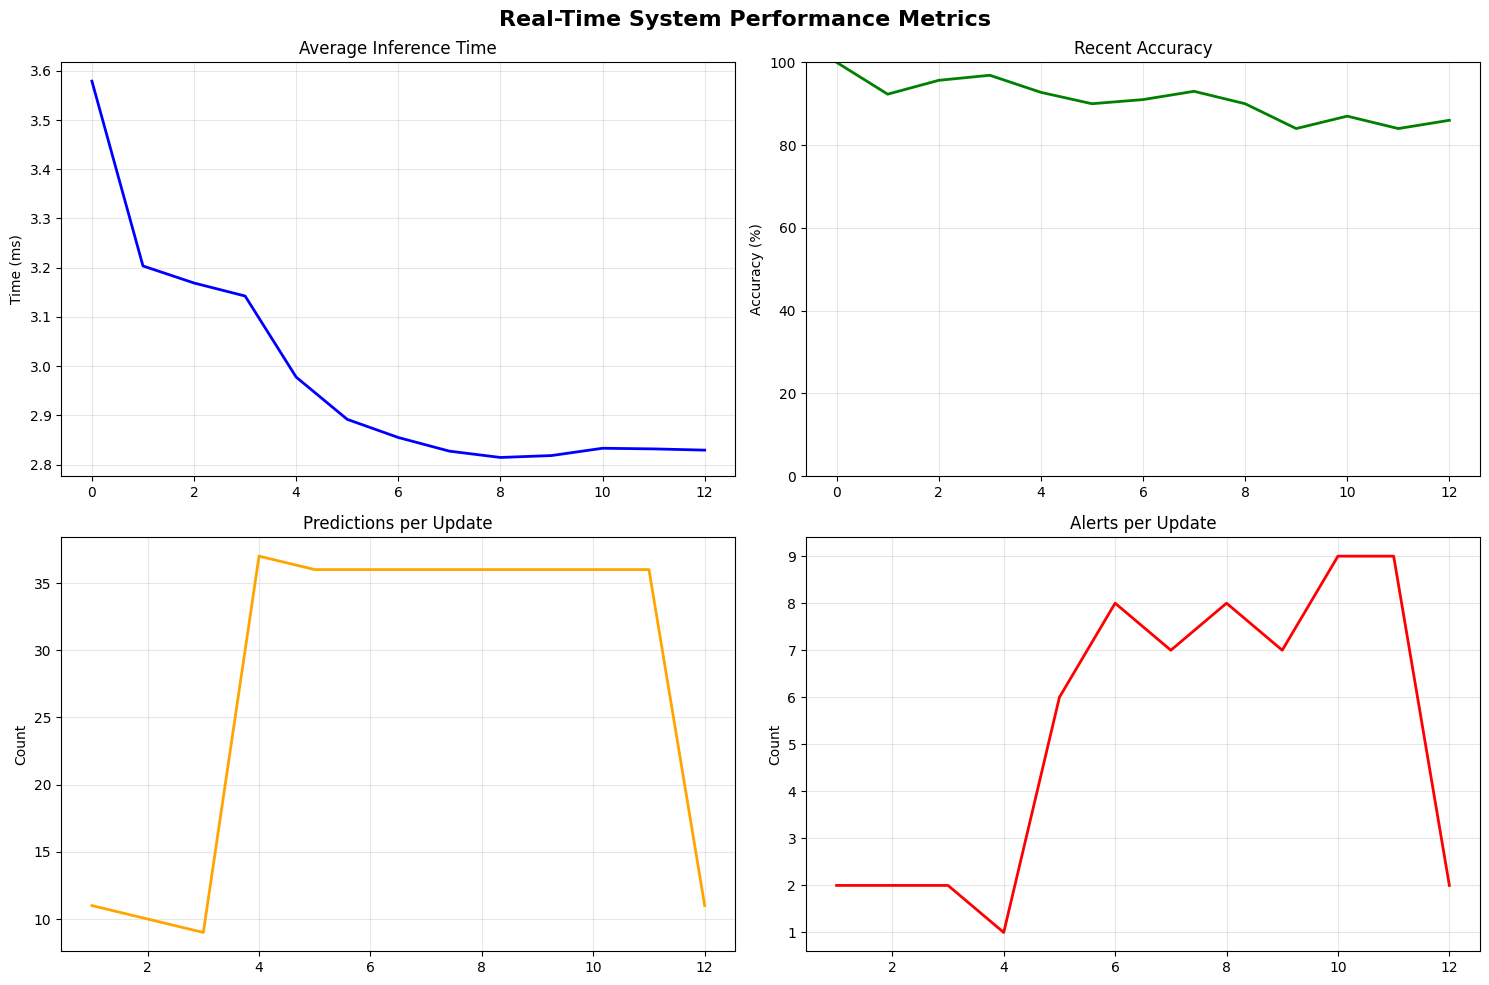


📊 Alert Timeline Analysis:
   Total alerts: 64
   Simulation duration: 73.5 seconds (1.2 minutes)
   Alert rate: 52.2 alerts/minute


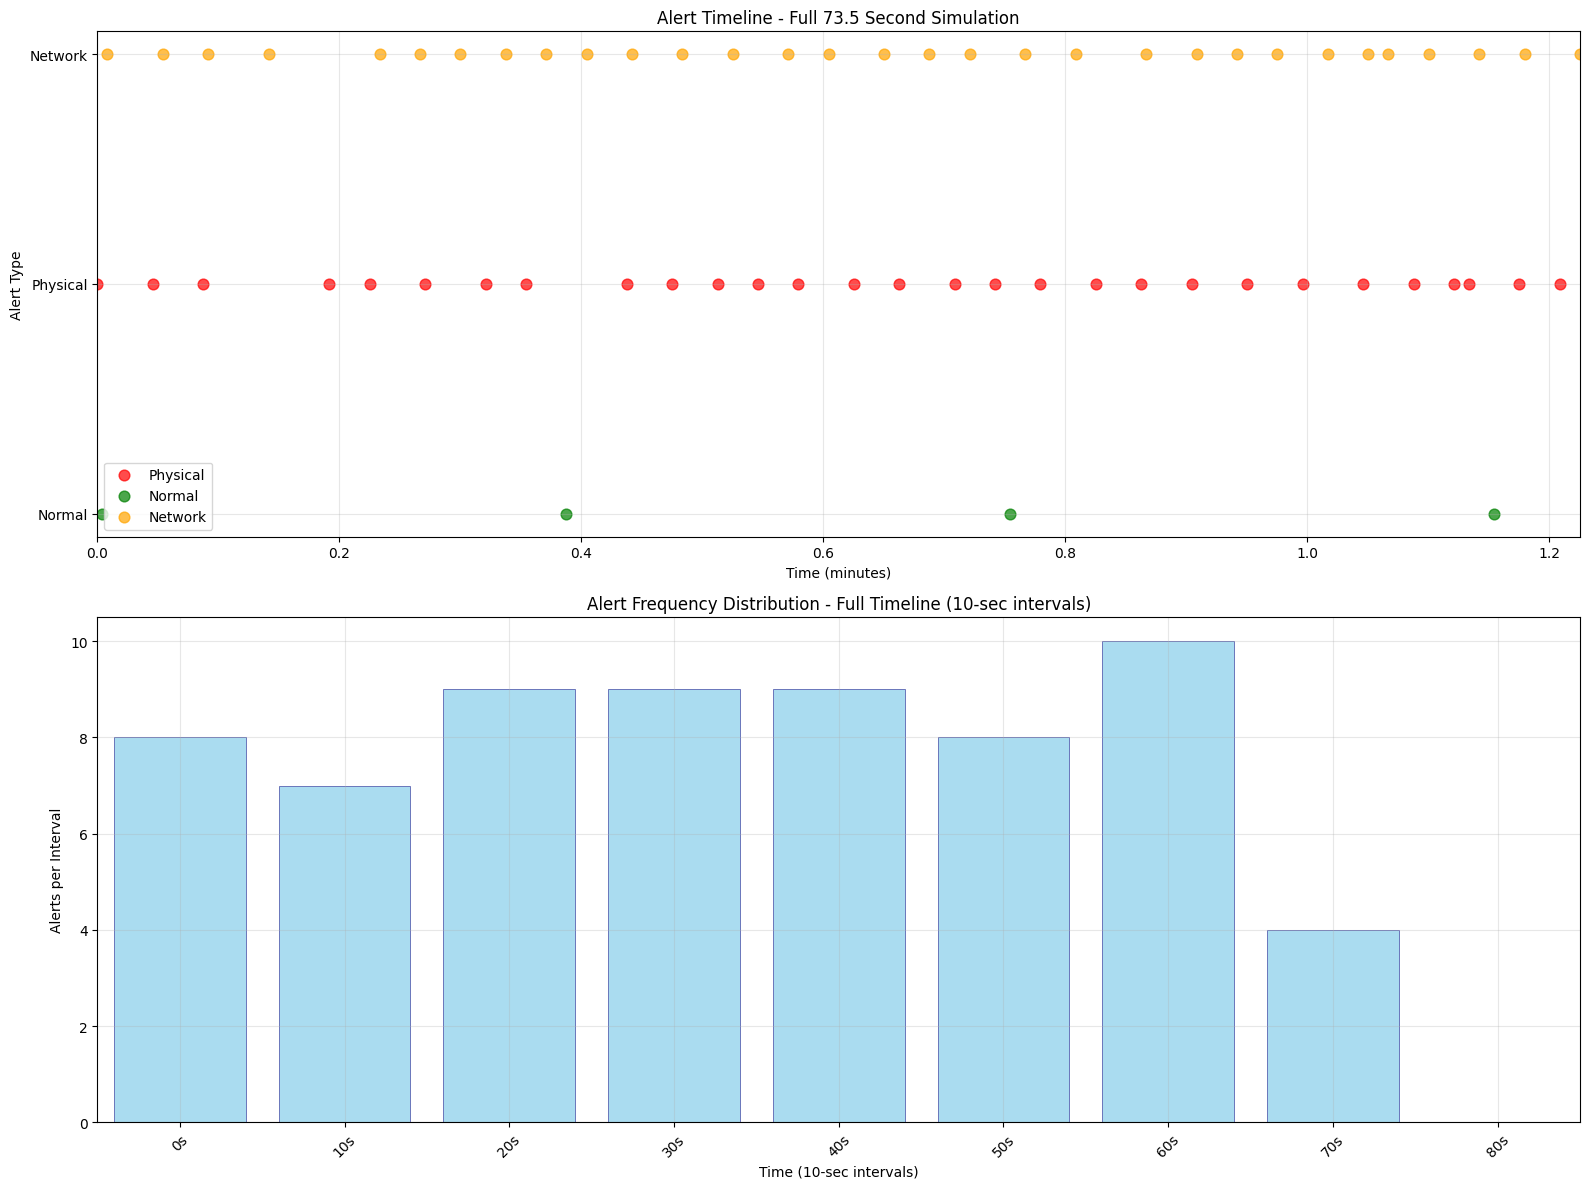


📈 Timeline Statistics:
   Time bins: 8 (10s each)
   Peak alerts in single interval: 10 alerts
   Average alerts per interval: 7.1
   Empty intervals: 1/8 (12.5%)


In [27]:
# Run the comprehensive simulation with full 75-second duration
comprehensive_results, comprehensive_alerts = run_comprehensive_alert_simulation(
    duration_seconds=75,  # Full 75 seconds for complete timeline
    samples_per_second=4
)